In [19]:
import os
import pytz, datetime, time
import json
import numpy as np
import pandas as pd
import base64, urllib2, json, requests
import pymysql.cursors
from sys import platform
import time, datetime
import matplotlib.pyplot as plt
from IPython.display import display    

def occpancy_stats():
    
    with open('data/Temperature_Occupancy_Meters.json') as k:
        rooms = json.load(k,encoding='latin1')
    
    if platform == 'linux' or platform == 'linux2':
        sock = "/var/run/mysqld/mysqld.sock"
    if platform == 'darwin':
        sock = "/tmp/mysql.sock"

    connection = pymysql.connect(host='localhost',
                                 user='root',
                                 password='',
                                 db='smart_energy',
                                 unix_socket = sock,
                                 cursorclass=pymysql.cursors.DictCursor)
    cursorObject = connection.cursor()
    
    start_date = ["2017-04-01","2017-05-01","2017-06-01"]
    end_date = ["2017-04-30","2017-05-31","2017-06-30"]
    room_names = ["A510","A515","A522","A523","A526","A527","A529"]

    st = " 00:00:00"
    et = " 23:59:00"
    
    
    # implement dictionary for NodeId to MeterId
    month_names = ['April','May','June']
    months = {}
    ts_counter = []
    d = ''
    for m in range(3):
        rooms_dict = {}
        for room_name in room_names: 
            for room in rooms:
                if room['RoomName'] == room_name:
                    break
            
            sd = datetime.datetime.strptime(start_date[m], "%Y-%m-%d")
            ed = datetime.datetime.strptime(end_date[m], "%Y-%m-%d")
            
            hourly_occupancy = []
            while sd <= ed:
                for node in room['RoomNodes']:
                    node_id = str(node['NodeId'])
                    for meter in node['OccupancyMeters']:
                        meter_id = str(meter['MeterId'])
                        query = "SELECT time " \
                                "FROM t_"+node_id+" " \
                                "WHERE (time > \""+sd.strftime("%Y-%m-%d")+st+"\") " \
                                "AND (time < \""+sd.strftime("%Y-%m-%d")+et+"\") " \
                                "AND (c_"+meter_id+" = 1)"

                        cursorObject.execute(query)
                        rows = cursorObject.fetchall()
                        if len(rows) > 0:
                            #print len(rows)
                            temp = [str(x['time']) for x in rows]
                            ts_counter = list(set().union(ts_counter, temp))
                
                hourly_occupancy.append(len(ts_counter)/12.0)
                sd = sd + datetime.timedelta(hours=24)
                ts_counter = []
                
            rooms_dict[room_name] = hourly_occupancy
            
        months[month_names[m]] = rooms_dict
    return months
    
months = occpancy_stats()

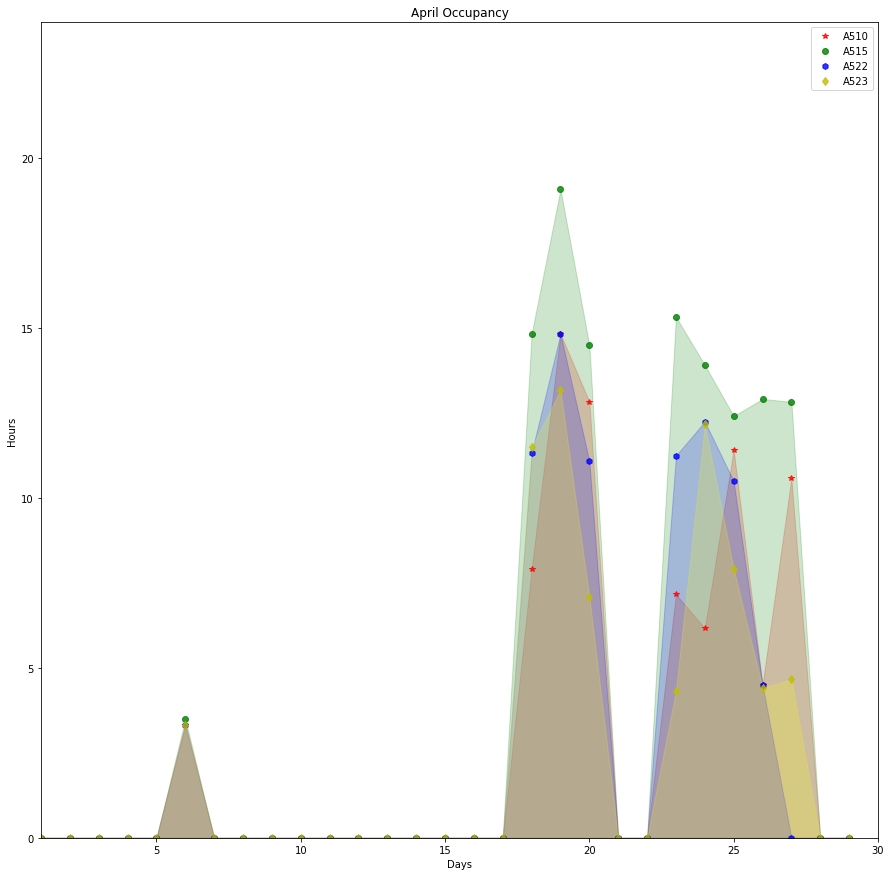

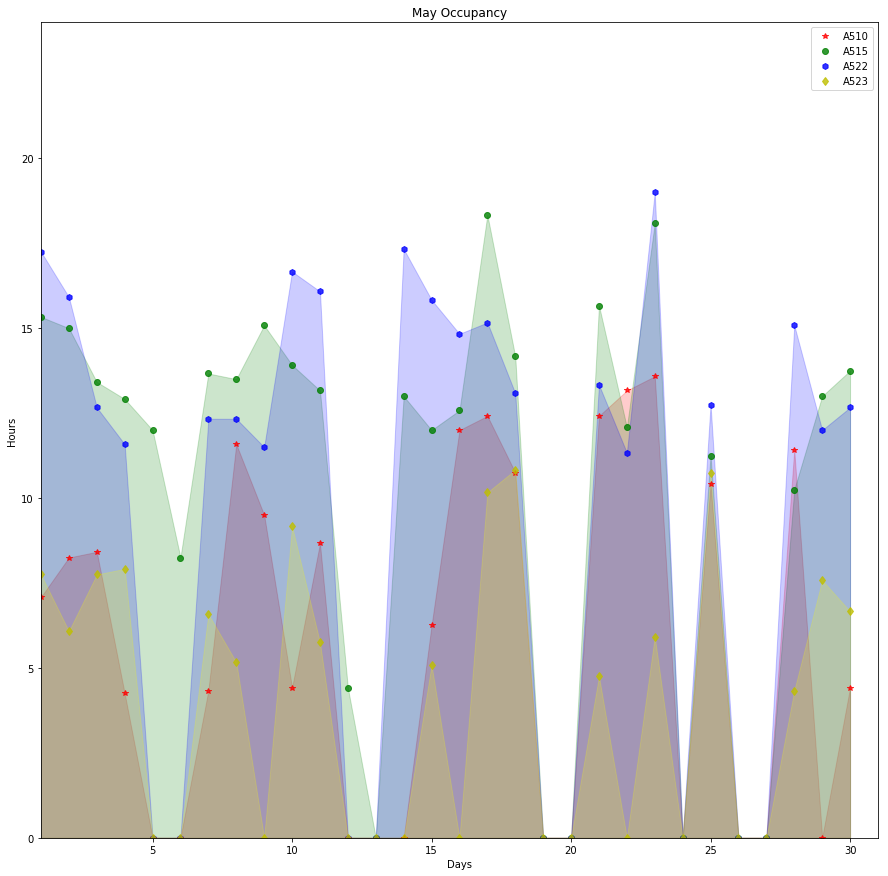

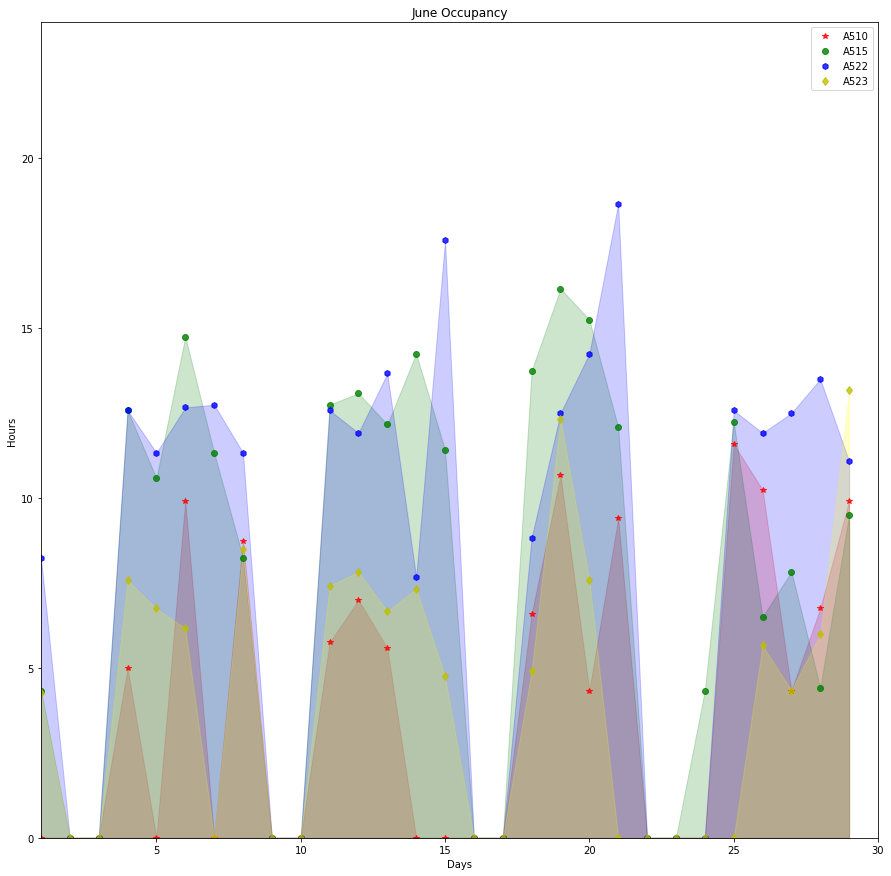

In [70]:
import scipy
mnth = ['April','May','June']
rooms = ["A510","A515","A522","A523"]#,"A526","A527","A529"]
colors = ['r','g','b','y','c','k','w']
marker = ['*','o','h','d','s','>','+']
color_names = ['red','green','blue','yellow','cyan','black','white']
for m in mnth:
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    for i,r in enumerate(rooms):
        ax.set_xlim([1,len(months[m][r])])
        ax.set_ylim([0,24])
        ax.plot(months[m][r], colors[i]+marker[i], label= r, alpha=0.8)
        d = scipy.zeros(len(months[m][r]))
        X = [x for x in range(0,len(months[m][r]))]
        ax.fill_between(X,d,months[m][r], interpolate=True, color=color_names[i], alpha=0.2)
        ax.legend(loc='best')
        ax.set_xlabel('Days')
        ax.set_ylabel('Hours')
        
    plt.title(m+" Occupancy")
plt.show()


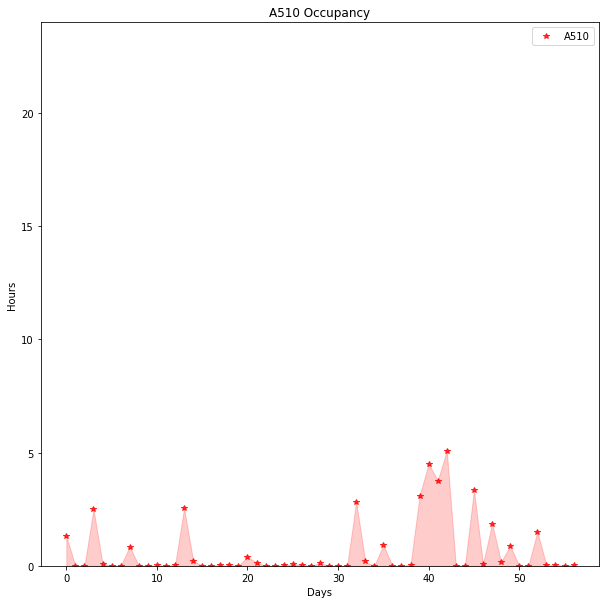

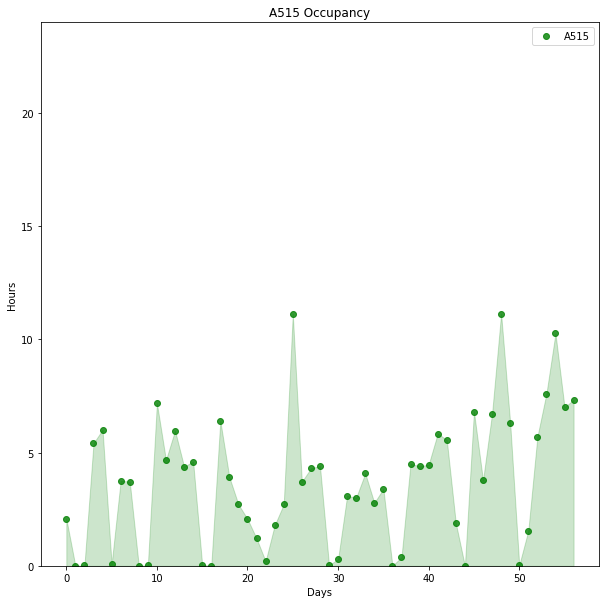

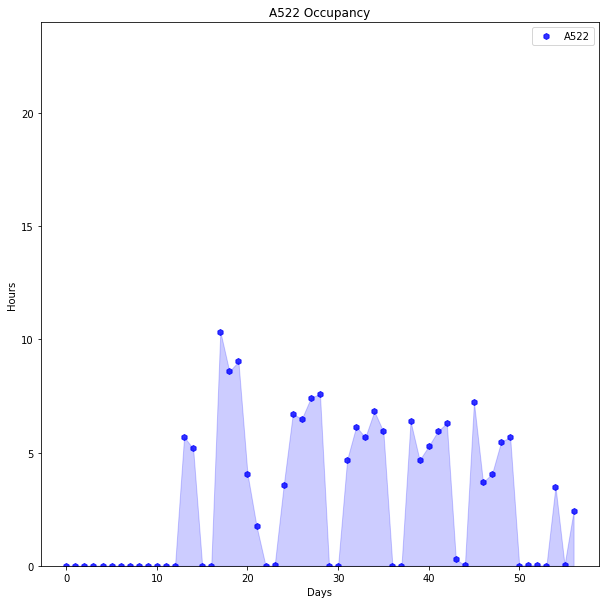

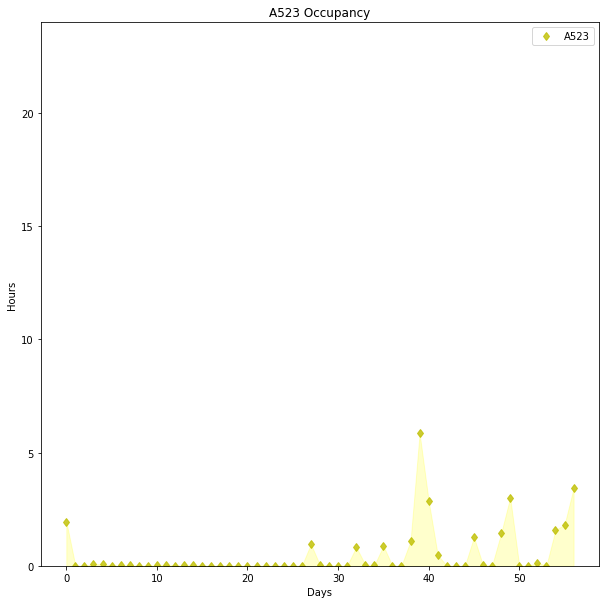

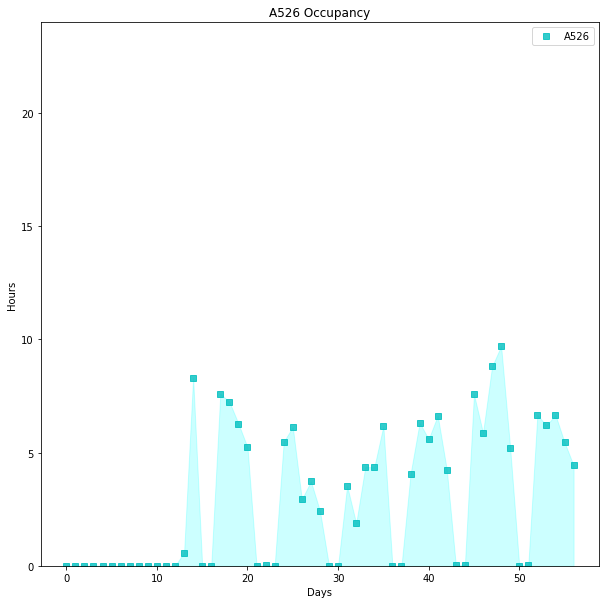

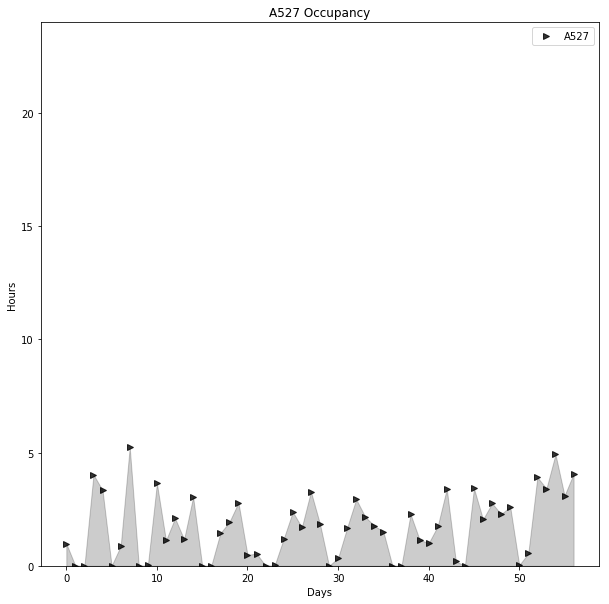

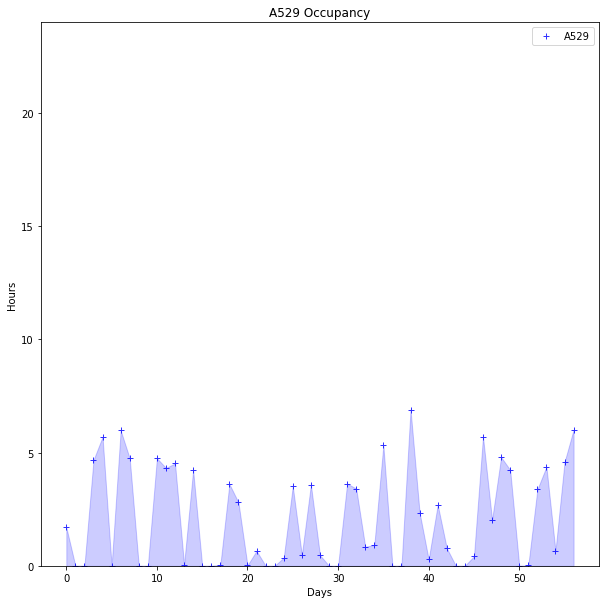

In [87]:
rooms = ["A510","A515","A522","A523","A526","A527","A529"]
colors = ['r','g','b','y','c','k','b']
marker = ['*','o','h','d','s','>','+']
color_names = ['red','green','blue','yellow','cyan','black','blue']

for i,r in enumerate(rooms):
    with open('data/UsageRate/'+r+'.txt') as k:
        temp = json.load(k,encoding='latin1')

    temperature = [float(t['Usage']) for t in reversed(temp)]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    #ax.set_xlim([1,len(months[m][r])])
    ax.set_ylim([0,24])
    ax.plot(temperature, colors[i]+marker[i], label= r, alpha=0.8)
    d = scipy.zeros(len(temperature))
    X = [x for x in range(0,len(temperature))]
    ax.fill_between(X,d,temperature, interpolate=True, color=color_names[i], alpha=0.2)
    ax.legend(loc='best')
    ax.set_xlabel('Days')
    ax.set_ylabel('Hours')
        
    plt.title(r+" Occupancy")
plt.show()

    